In [4]:
import os
import pickle
from collections import defaultdict
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
def parse_results(directory, length_param_grid):
    
    files = [x for x in os.listdir(directory) if 'results' in x and '.txt.txt' not in x]

    results_dict = defaultdict(lambda:0)
    number_runs = defaultdict(lambda:0)
    all_params = []

    for file in files:
        param = int(file.split('_')[-2][1:])
        run_number = int(file.split('_')[-1].split('.')[0][1:])

        with open(directory+file, 'rb') as f:
            result = pickle.load(f)

        results_dict[param] += sum(result['presence_VR'])
        number_runs[param] += 10

        all_params.append((param, run_number))

    results_dict = dict(results_dict)
    
    # check that all runs are present
    missing = set(product(range(length_param_grid), range(100))).symmetric_difference(set(all_params))
    if len(missing) == 0:
        print('All runs have been parsed')
    else:
        print('Some runs are missing:', missing)
    
    percentage_takeover = dict(zip(list(results_dict.keys()), [results_dict[p]/number_runs[p] for p in list(results_dict.keys())]))
    confidence_intervals =  dict(zip(list(results_dict.keys()),[1.96*np.sqrt((percentage_takeover[p]*(1-percentage_takeover[p]))/1000) for p in list(results_dict.keys())]))
    
    return(percentage_takeover, confidence_intervals)

In [6]:
def get_index(df, desired_dict):

    subdf = df.copy()

    for keyval in desired_dict:
        if keyval in subdf.columns:
            subdf = subdf[subdf[keyval] == desired_dict[keyval]]
        
    # check that index unique
    if len(list(subdf.index)) != 1:
        print('Index not unique')
        
    return(subdf.index[0])

def get_paramgrid(file):
    with open(file, 'rb') as f:
        paramgrid = pickle.load(f)
    df = pd.DataFrame(paramgrid)  
    return(df)

In [7]:
basic_results, basic_ci = parse_results('bar_chart/basic_model/', 72)
social_distancing_results, social_distancing_ci = parse_results('bar_chart/social_distancing/', 72)
vaccine_hesitancy_results, vaccine_hesitancy_ci = parse_results('bar_chart/vaccine_hesitancy/', 144)
seasonality_results, seasonality_ci = parse_results('bar_chart/seasonality/',64)

All runs have been parsed
All runs have been parsed
All runs have been parsed
All runs have been parsed


In [8]:
all_simulations = ['basic', 'social_distancing', 'vaccine_hesitancy', 'seasonality']

paramgrid_files = {'basic':'bar_chart/basic_model/paramgrid_appearance_barchart_basic.txt', 
                  'social_distancing':'bar_chart/social_distancing/paramgrid_appearance_barchart_socialdistancing.txt',
                  'vaccine_hesitancy':'bar_chart/vaccine_hesitancy/paramgrid_appearance_barchart_vaccinehesitancy.txt',
                  'seasonality':'bar_chart/seasonality/paramgrid_appearance_barchart_seasonality.txt'}

df_basic, df_social_distancing, df_vaccine_hesitancy, df_seasonality = [get_paramgrid(paramgrid_files[file]) for file in all_simulations]

dfs = dict(zip(all_simulations, [df_basic, df_social_distancing, df_vaccine_hesitancy, df_seasonality]))
all_results = dict(zip(all_simulations, [basic_results, social_distancing_results, vaccine_hesitancy_results, seasonality_results])) 
all_ci = dict(zip(all_simulations, [basic_ci, social_distancing_ci, vaccine_hesitancy_ci, seasonality_ci])) 

In [20]:
h = 0.3
q = 1
delta = 2
mu = 1e-6
season = 0.9
f = 2
N =1e6

combs_cl = [(100,1000),(100,10000),(500,1000),(500,10000)]

In [21]:
all_bar_results = [] 
all_bar_ci = [] 

for L, c in combs_cl:
    bar_results = defaultdict(list)
    bar_ci = defaultdict(list)
    desired_dict = {'delta':delta, 'mu':mu, 'q':q, 'c':c, 'i_threshold':L, 'hesitancy':h, 'season':season}

    for sim in all_simulations:
        bar_results[sim] = all_results[sim][get_index(dfs[sim], desired_dict)]
        bar_ci[sim] = all_ci[sim][get_index(dfs[sim], desired_dict)]

    desired_dict['season'] = 1.1
    bar_results['seasonality2'] = all_results[sim][get_index(dfs[sim], desired_dict)]
    bar_ci['seasonality2'] = all_ci[sim][get_index(dfs[sim], desired_dict)]
    
    TH = N/(L+c)*(2/3)
    bar_results['theory'] = 1-delta_theory(TH, N, mu, L, c, f)
    bar_ci['theory'] = 0
    
    all_bar_results.append(list(bar_results.values()))
    all_bar_ci.append(list(bar_ci.values()))

In [22]:
all_labels = ['Basic Model', 'Social Distancing Every Week', 'Vaccine Hesitancy 30%', 'Seasonality: 10% Infectivity Decrease in Winter', 'Seasonality: 10% Infectivity Increase in Winter', 'Analytical Prediction']

In [23]:
def delta_theory(t, N, mu, L, c, f):
    p1 = -L*mu*((f-1)/f)*t
    p2 = -L*mu*((c+L)/(2*N*f))*t**2
    return(np.exp(p1+p2))

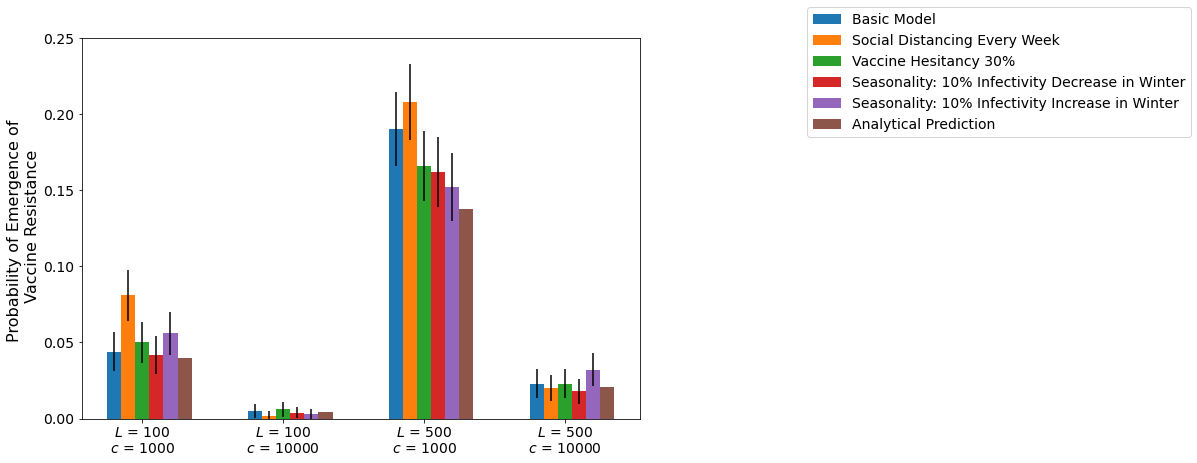

In [25]:
x = np.arange(0,4.,1)  # the label locations
width = 0.1  # the width of the bars
pos = np.arange(0,3.,0.5)

fig, ax = plt.subplots(figsize = (10,7))

for n in range(6):
    bars = ax.bar(x + pos[n]*width*2, np.array(all_bar_results)[:,n], width, yerr = np.array(all_bar_ci)[:,n], label=all_labels[n])
    

ax.set_ylabel('Probability of Emergence of \n Vaccine Resistance', fontsize = 16)
ax.set_xticks(x+0.2)
ax.set_xticklabels(['$L$ = ' + str(x[0]) + '\n$c$ = ' + str(x[1])  for x in combs_cl], fontsize = 14)
ax.legend(fontsize = 14, bbox_to_anchor = (2.,1.1))
ax.set_ylim(0.,0.25)
ax.tick_params(labelsize = '14')

plt.savefig('Fig_SEP14_delta2_mu6.jpg', dpi=400)

In [14]:
def parse_results_death(directory, length_param_grid):
    
    files = [x for x in os.listdir(directory) if 'results' in x]

    results_dict = defaultdict(lambda:0)
    number_runs = defaultdict(lambda:0)
    all_params = []

    for file in files:
        param = int(file.split('_')[-2][1:])
        run_number = int(file.split('_')[-1].split('.')[0][1:])

        with open(directory+file, 'rb') as f:
            result = pickle.load(f)

        #print(result)
        results_dict[param] += sum(result['death_rates'])/10
        number_runs[param] += 10

        all_params.append((param, run_number))

    results_dict = dict(results_dict)
    
    # check that all runs are present
    missing = set(product(range(length_param_grid), range(100))).symmetric_difference(set(all_params))
    if len(missing) == 0:
        print('All runs have been parsed')
    else:
        print('Some runs are missing:', missing)
    
    percentage_takeover = dict(zip(list(results_dict.keys()), [results_dict[p]/number_runs[p] for p in list(results_dict.keys())]))    
    return(percentage_takeover)

In [129]:
social_distancing_results_death = parse_results_death('bar_chart/social_distancing/', 72)

All runs have been parsed


In [130]:
basic_results_death= parse_results_death('bar_chart/basic_model/', 72)
social_distancing_results_death = parse_results_death('bar_chart/social_distancing/', 72)
vaccine_hesitancy_results_death = parse_results_death('bar_chart/vaccine_hesitancy/', 144)
seasonality_results_death = parse_results_death('bar_chart/seasonality/',64)

KeyError: 'death_rates'